In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import time
pd.set_option('display.max_columns', 30)

In [1]:
# you can change the resolution(in meters) here, and click run all. resolution = 30 means 30m resolution.
resolution = 900
lon_per_meter = 0.000008983
lat_per_meter = 0.000010966
lon_resolution = resolution * lon_per_meter
lat_resolution = resolution * lat_per_meter

In [5]:
# read shp file into geopandas dataframe
species = gpd.read_file('.\Data\MAMMALS\MAMMALS\MAMMALS.shp')

# read geojson file into geopandas dataframe
# cr_bounds = gpd.read_file('.\Data\CR_Crop3.geojson')
# cr_polygon = cr_bounds.geometry[0]

# get Costa Rica map and its bounds
cr_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).query('name == "Costa Rica"')
cr_polygon=cr_map['geometry'].to_list()[0]

C:\Users\Jinze Wang\AppData\Local\Temp\ipykernel_7888\3275148424.py:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  cr_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).query('name == "Costa Rica"')


In [15]:
# # draw cr_polygon on cr map
# fig, ax = plt.subplots(figsize=(10,10))
# cr_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).query('name == "Costa Rica"')
# cr_map.plot(ax=ax, color='white', edgecolor='black')
# gpd.GeoSeries(cr_polygon).plot(ax=ax, color='red', alpha=0.5)

In [13]:
# filter out species that is extinct(contains 'extinct' in legend)
species = species[~species['legend'].str.contains('Extinct')]
# choose only species in CR
cr_species = species[species.geometry.intersects(cr_polygon)]
# get the intersection area of each species with CR
cr_species['intersection_geometry'] = cr_species.geometry.intersection(cr_polygon)
cr_species_geo = cr_species.intersection_geometry
cr_species.head()

C:\Users\Jinze Wang\AppData\Roaming\Python\Python311\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,id_no,binomial,presence,origin,seasonal,compiler,yrcompiled,citation,subspecies,subpop,source,island,tax_comm,dist_comm,generalisd,legend,kingdom,phylum,class,order_,family,genus,category,marine,terrestial,freshwater,SHAPE_Leng,SHAPE_Area,geometry,intersection_geometry
32,11350,Lasiurus ega,1,1,1,IUCN,2016,IUCN (International Union for Conservation of ...,None,None,None,None,None,None,0,Extant (resident),ANIMALIA,CHORDATA,MAMMALIA,CHIROPTERA,VESPERTILIONIDAE,Lasiurus,LC,false,true,false,412.779129,1114.037843,"MULTIPOLYGON (((-49.71090 -29.31436, -49.71500...","MULTIPOLYGON (((-83.59660 8.89314, -83.60090 8..."
60,19417,Reithrodontomys sumichrasti,1,1,1,IUCN,2008,IUCN (International Union for Conservation of ...,None,None,None,None,None,None,0,Extant (resident),ANIMALIA,CHORDATA,MAMMALIA,RODENTIA,CRICETIDAE,Reithrodontomys,LC,false,true,false,75.178567,27.927096,"MULTIPOLYGON (((-83.70519 9.79434, -83.67297 9...","POLYGON ((-83.67297 9.76615, -83.58636 9.82354..."
93,9948,Herpailurus yagouaroundi,1,1,1,IUCN,2015,IUCN (International Union for Conservation of ...,None,None,None,None,None,None,0,Extant (resident),ANIMALIA,CHORDATA,MAMMALIA,CARNIVORA,FELIDAE,Herpailurus,LC,false,true,false,509.592882,1252.301920,"POLYGON ((-83.59660 8.89314, -83.59109 8.89314...","MULTIPOLYGON (((-83.59109 8.89314, -83.59053 8..."
99,41683,Nasua narica,1,1,1,IUCN,2016,IUCN (International Union for Conservation of ...,None,None,None,None,None,None,0,Extant (resident),ANIMALIA,CHORDATA,MAMMALIA,CARNIVORA,PROCYONIDAE,Nasua,LC,false,true,false,277.865299,235.977334,"MULTIPOLYGON (((-74.48553 10.98502, -74.47376 ...","MULTIPOLYGON (((-82.97765 8.23536, -82.98412 8..."
124,11511,Leopardus wiedii,1,1,1,IUCN,2015,International Union for the Conservation of Na...,None,None,None,None,None,None,0,Extant (resident),ANIMALIA,CHORDATA,MAMMALIA,CARNIVORA,FELIDAE,Leopardus,NT,false,true,false,501.047714,1024.720857,"MULTIPOLYGON (((-55.07801 -33.16986, -55.51064...","MULTIPOLYGON (((-83.65159 10.91337, -83.63886 ..."


In [19]:
# create points to represent 30*30 m grid in CR
# should be 0.00027
x = np.arange(cr_polygon.bounds[0],cr_polygon.bounds[2],lon_resolution)
y = np.arange(cr_polygon.bounds[1],cr_polygon.bounds[3],lat_resolution)
points = []
for i in x:
    for j in y:
        p=shapely.geometry.Point(i,j)
        # There are too many points, so we only includes points that are within CR
        if p.within(cr_polygon):
            points.append(shapely.geometry.Point(i,j))
len(points)

17338

In [22]:
# create a list to reord the number of species in each grid
# tract the time
start = time.time()
species_count = []
for p in points:
    species_count.append(sum(cr_species_geo.contains(p)))
end = time.time()
print("Time spent on {} points: {} seconds".format(len(points), end-start))

Time spent on 17338 points: 1409.7176642417908 seconds


In [23]:
# create a dataframe to store the number of species in each grid
species_count_df = gpd.GeoDataFrame({'geometry':points,'species_count':species_count})

In [24]:
species_count_df[species_count_df['species_count']>0]

,geometry,species_count
0,POINT (-85.92573 10.89703),98
1,POINT (-85.90973 10.88103),26
2,POINT (-85.90973 10.89703),99
3,POINT (-85.90973 10.91303),26
4,POINT (-85.89373 10.88103),27
...,...,...
17333,POINT (-82.59773 9.60103),29
17334,POINT (-82.58173 9.56903),125
17335,POINT (-82.58173 9.58503),29
17336,POINT (-82.56573 9.56903),38


Text(0.5, 1.0, 'Mammal Species Count in CR')

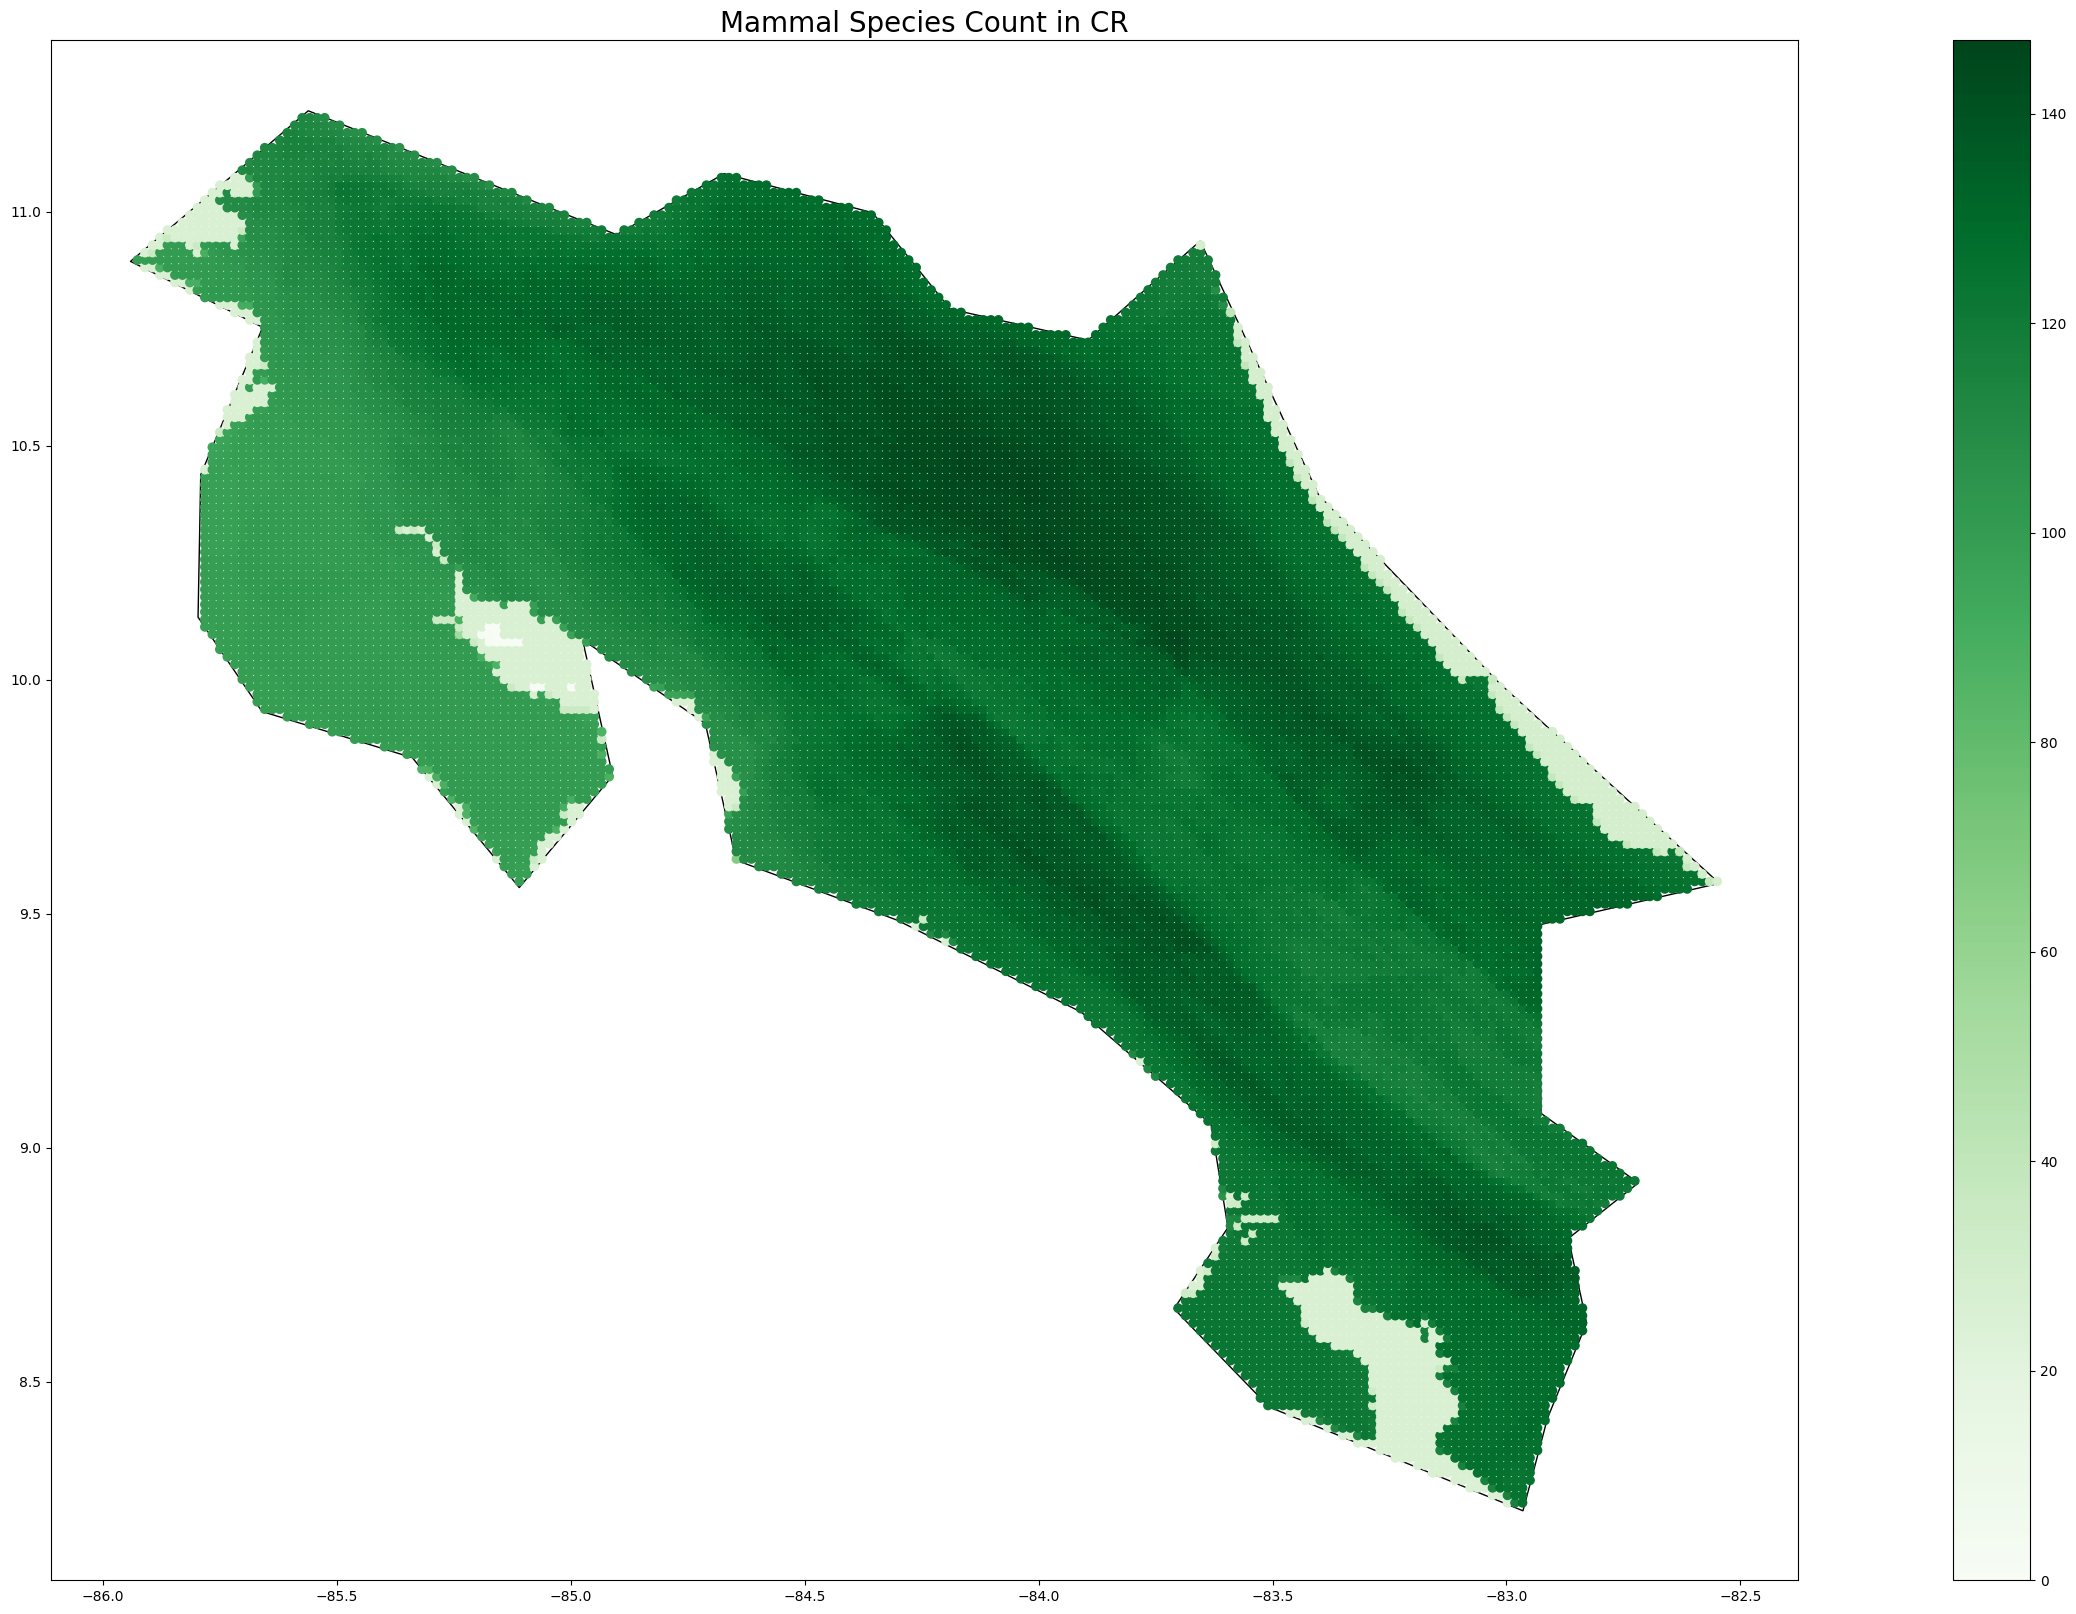

In [25]:
# plot CR map with species count
fig, ax = plt.subplots(figsize=(40,20))
# gpd.GeoSeries(cr_polygon).plot(ax=ax, color='white', edgecolor='black')
# plot costa rica map
cr_map.plot(ax=ax, color='white', edgecolor='black')
# use a colormap to plot the species count
species_count_df.plot(ax=ax, column='species_count', legend=True, cmap='Greens')
# set the title
ax.set_title('Mammal Species Count in CR', fontsize=20)

In [1]:
# save the species_count_df to a csv file
species_count_df.to_csv('.\Data\species_count.csv')

NameError: name 'species_count_df' is not defined